# Project description
### Car salling organization used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value.

**Main goals of he project:**
- quality of the prediction
- speed of the prediction
- time required for training


### Features
- DateCrawled — date profile was downloaded from the database
- VehicleType — vehicle body type
- RegistrationYear — vehicle registration year
- Gearbox — gearbox type
- Power — power (hp)
- Model — vehicle model
- Mileage — mileage (measured in km due to dataset's regional specifics)
- RegistrationMonth — vehicle registration month
- FuelType — fuel type
- Brand — vehicle brand
- NotRepaired — vehicle repaired or not
- DateCreated — date of profile creation
- NumberOfPictures — number of vehicle pictures
- PostalCode — postal code of profile owner (user)
- LastSeen — date of the last activity of the user
### Target
- Price — price (Euro)

### Step 1. Import our packages , Load and prepare our Data 

In [5]:
#Importing necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
import plotly.express as px
import optuna
import time
from boruta import BorutaPy
from sklearn.feature_selection import SelectKBest,mutual_info_regression
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import plot_tree

from optuna.visualization import plot_optimization_history,plot_intermediate_values

In [6]:
#Loading and showing the data set

try:
    df = pd.read_csv('car_data.csv')
    display(df.sample(5))
    display(df.info())
except:
    print('Wasted')

DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
53165   02/04/2016 17:51    700       sedan              1999  manual    109   
307406  22/03/2016 16:55    700       small              1999  manual      0   
306077  19/03/2016 10:53    599         NaN              2017     NaN      0   
71626   26/03/2016 11:52    450       wagon              2003  manual    150   
177734  02/04/2016 19:48   9800       small              2014  manual     63   

         Model  Mileage  RegistrationMonth  FuelType       Brand NotRepaired  \
53165   scenic   150000                  4    petrol     renault          no   
307406   other   150000                  1    petrol       rover         NaN   
306077   caddy   150000                  0  gasoline  volkswagen         NaN   
71626      156   150000                  0  gasoline  alfa_romeo         yes   
177734   ibiza    30000                  3    petrol        seat          no   

             DateCreated  NumberOfPictures  PostalCode          LastSeen  
53165   02/04/2016 00:00                 0       66113  06/04/2016 17:17  
307406  22/03/2016 00:00                 0       45888  28/03/2016 07:47  
306077  19/03/2016 00:00                 0       59379  19/03/2016 11:42  
71626   26/03/2016 00:00                 0       37603  26/03/2016 12:43  
177734  02/04/2016 00:00                 0       58300  06/04/2016 20:16

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

In [7]:
#Making our features titles to lowercase register
df.columns = df.columns.str.lower()

In [8]:
#Checking missing values in our dataset
print(df.isnull().sum())
print()
print('The % of missing values in data set compare to all values is: {:.2%}'.format((df.isnull().sum().sum()) / len(df)))

datecrawled              0
price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
mileage                  0
registrationmonth        0
fueltype             32895
brand                    0
notrepaired          71154
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

The % of missing values in data set compare to all values is: 51.10%


In [9]:
#Number of duplicates
df.duplicated().sum()

262

> **Conclusion**: Seems we have a lot of missing values, which means first we will start solving the problems step by step working with each feature independently. The number of our duplicates is not significant why I propose not paying any attention to this problem and moving on with the missing values solution


In [10]:
#Start workig with first features "VehicleType"
df['vehicletype'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

> Our project discription didn't provide to us any necessary information about whay to do with our "Nan" values, that why I propose to fill all of them, by category type **"other"** and move on to the next features

In [11]:
#Creating function that will make our life a bit easier in the next step
def fill_miss(data,col,val):
    data[col] = data[col].fillna(val)
    return data

df = fill_miss(df,'vehicletype','other')
df['vehicletype'].value_counts()

sedan          91457
small          79831
wagon          65166
other          40778
bus            28775
convertible    20203
coupe          16163
suv            11996
Name: vehicletype, dtype: int64

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.15 µs


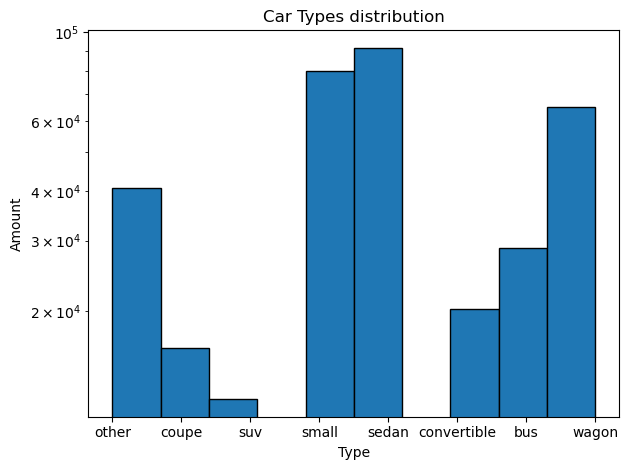

In [12]:
%time
#Checking what kind of distribution bettwen our car types we have 

plt.hist(df['vehicletype'], edgecolor = 'black', log=True)
plt.title("Car Types distribution")
plt.xlabel('Type')
plt.ylabel('Amount')
plt.tight_layout()

>**Conclusion:** Seems all working properly, now we can move on to our **"Gearbox"** features here we do not have any instructions on how we can handle our missing values so we will choose our way. I propose to fill all missing values by the **auto** which will be good in our next step when we fit our model, which will give a smaller impact of the overfitting model. 

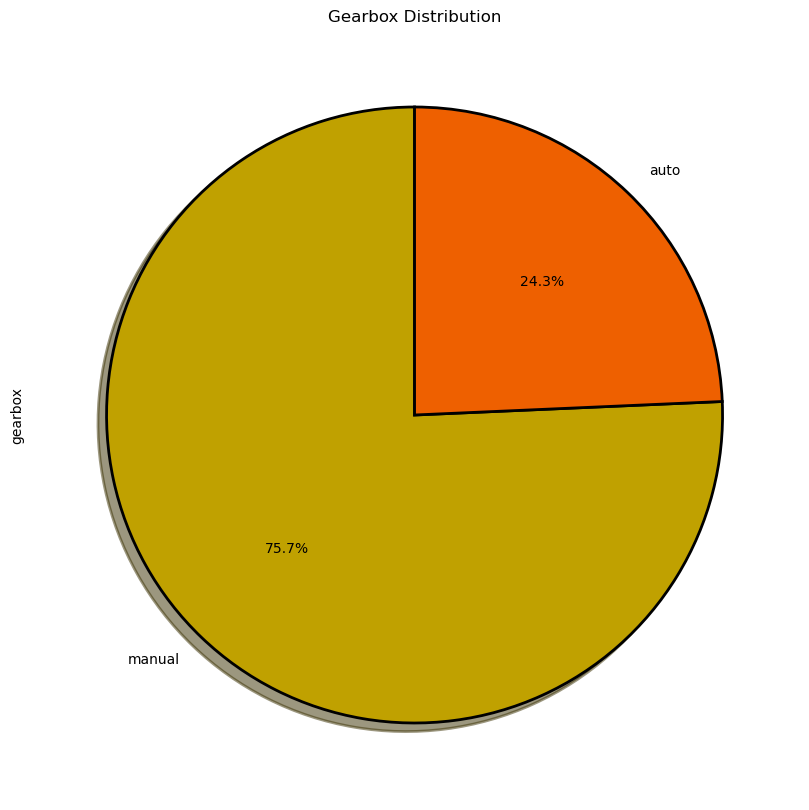

In [13]:
#Filling missing values
df = fill_miss(df,'gearbox','auto')
#Checking from the inside
#Creating a pie chart to show what kind of gearbox distribution we have b
colors = ['#c0a100','#ee6000']
explode = [0,0]
df['gearbox'].value_counts().plot.pie(explode = explode, shadow = True, colors = colors, startangle = 90,
                                                         wedgeprops = {"edgecolor" : "black",'linewidth': 2,
                                                                       'antialiased': True},
                                                         autopct='%1.1f%%',figsize=(10,10),title= "Gearbox Distribution");

In [14]:
#Checking "Model" features
df['model'].value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64

> Here we have **"Other"** value, as we did in the previous step, I propose to fill all missing values by **"Other"** and move to the next step

In [15]:
#Filling missing values
df = fill_miss(df,'model','other')
df['model'].value_counts()

other                 44126
golf                  29232
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64

In [16]:
#Creating a new data set that show what kind of  fueltype distribution we have in our dataset
engine_dist = pd.DataFrame(df['fueltype'].value_counts().reset_index().rename(columns = {'index':'fueltype',
                                                                                      'fueltype':'amount'}))
engine_dist


fueltype  amount
0    petrol  216352
1  gasoline   98720
2       lpg    5310
3       cng     565
4    hybrid     233
5     other     204
6  electric      90

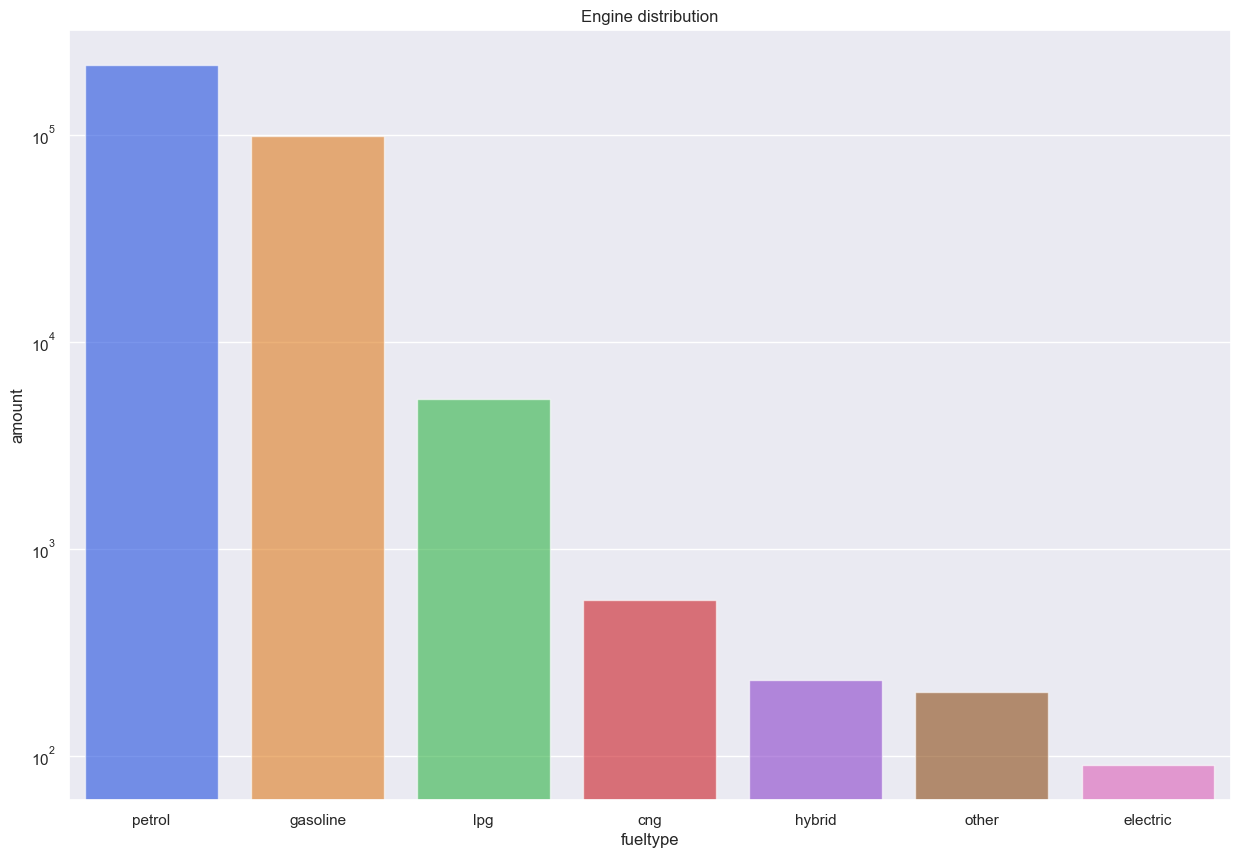

In [17]:
#Plotiing our new data set to show what type of engine our clients prefer most
sns.set(rc={"figure.figsize":(15, 10)})
sns.barplot(data=engine_dist, x='fueltype', y='amount', palette='bright', alpha=0.6, log=True).set(title='Engine distribution');


> In my opinion, nowadays, most of our cars belong to the fuel category **petrol-gasoline** so I propose to fill all the missing values with gasoline because here we have enough values in the petrol type, we make a bit of mixing in our feature, and will save our data from  **overfitting** in our data set.

In [18]:
#Filling missing values
df = fill_miss(df,'fueltype','gasoline')
df['fueltype'].value_counts()

petrol      216352
gasoline    131615
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fueltype, dtype: int64

In [19]:
#And our last feature with missing values 
df['notrepaired'].value_counts()

no     247161
yes     36054
Name: notrepaired, dtype: int64

> Here we can say that the car condition can be **repaired** or **not repaired**, but we don't know what kind of condition of car we have and what we need to do with missing values that is why I propose simply refill our missing values in this features by **"unknown"** so we will understand that we don't know what car condition we have.


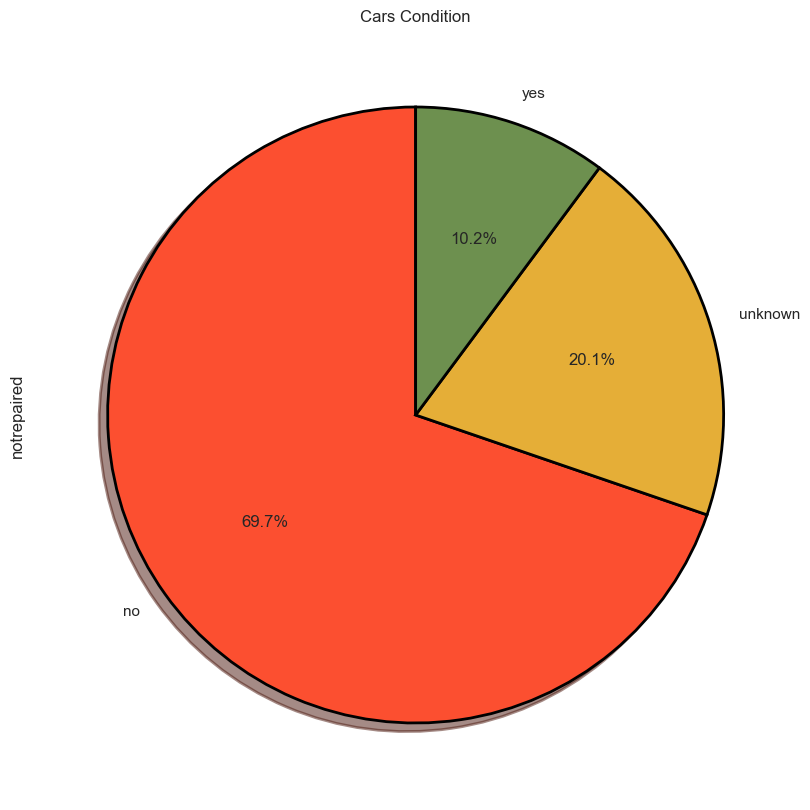

In [20]:
#filling all missing values by "unknown"
df = fill_miss(df,'notrepaired','unknown')
#Creating a pie chart to show what kind of car condition distribution we have 

colors = ['#fc4f30','#e5ae37','#6d904f']
explode = [0,0,0]
df['notrepaired'].value_counts().plot.pie(explode = explode, shadow = True, colors = colors, startangle = 90,
                                                         wedgeprops = {"edgecolor" : "black",'linewidth': 2,
                                                                       'antialiased': True},
                                                         autopct='%1.1f%%',figsize=(10,10),title= "Cars Condition");

In [21]:
#Let's change the type of our columns that our Ordinal-Encoder will be work properly and will free a bit of memory
columns=['datecrawled','vehicletype','gearbox','model','fueltype','brand','notrepaired','datecreated','lastseen']
df[columns] = df[columns].astype('string')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  string
 1   price              354369 non-null  int64 
 2   vehicletype        354369 non-null  string
 3   registrationyear   354369 non-null  int64 
 4   gearbox            354369 non-null  string
 5   power              354369 non-null  int64 
 6   model              354369 non-null  string
 7   mileage            354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           354369 non-null  string
 10  brand              354369 non-null  string
 11  notrepaired        354369 non-null  string
 12  datecreated        354369 non-null  string
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  string
dtypes: int64(7), string(

In [22]:
#Assing new variable with names of our columns
columns_date = ['datecrawled','datecreated','lastseen']
#Creating our convert types function
def conv_date(data,col):
    data[col] = pd.to_datetime(data[col])
    return data

df = conv_date(df,'datecrawled')
df = conv_date(df,'datecreated')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        354369 non-null  datetime64[ns]
 1   price              354369 non-null  int64         
 2   vehicletype        354369 non-null  string        
 3   registrationyear   354369 non-null  int64         
 4   gearbox            354369 non-null  string        
 5   power              354369 non-null  int64         
 6   model              354369 non-null  string        
 7   mileage            354369 non-null  int64         
 8   registrationmonth  354369 non-null  int64         
 9   fueltype           354369 non-null  string        
 10  brand              354369 non-null  string        
 11  notrepaired        354369 non-null  string        
 12  datecreated        354369 non-null  datetime64[ns]
 13  numberofpictures   354369 non-null  int64   

> **Conclusion**: Now that we finished work with our missing values, let's start analyzing another features in our data set, and check what we have inside each of them. Let's start with **$Registration Year$**.

In [23]:
#Describing car year distribution in our feature
df['registrationyear'].describe()

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registrationyear, dtype: float64

> Here we see that we have problematic values that can provide a bit of a negative impact while we train and work with our algorithm, that is why I propose to start working with them and clean up this mess here. I propose to check how many cars we have in a range between 1960 - 2019 and then we will check how many of our cars lie out of this range.

In [24]:
#Checking how many cars belong to a right year
df_upd = df.query('registrationyear > 1960 and registrationyear < 2020')
print('The number of cars lies in the right range is: {:.2%}'.format(len(df_upd) / len(df)))

The number of cars lies in the right range is: 99.80%


> We see that we have only 0.2% of our cars that can bring us in the wrong direction, that is why I propose simply going further with our correct data. But first, let's create new features that will help us train our model and add a bit of accuracy to our prediction.

In [25]:
#Creating a feature that will show us how old each car is 
df_upd['ageofcar'] = abs(df_upd['datecreated'].dt.year - df_upd['registrationyear'])
df_upd.sample(5)

datecrawled  price vehicletype  registrationyear gearbox  \
273688 2016-03-22 23:57:00  10700       small              2015  manual   
160826 2016-03-26 23:36:00   9750       wagon              2011  manual   
110940 2016-08-03 21:48:00   2850       coupe              2001  manual   
121234 2016-06-03 23:36:00   5290       wagon              2006    auto   
87833  2016-03-20 11:47:00    900       other              2017  manual   

        power   model  mileage  registrationmonth  fueltype          brand  \
273688     90  twingo     5000                  6    petrol        renault   
160826    105    golf    60000                 10  gasoline     volkswagen   
110940    118     3er   150000                  2    petrol            bmw   
121234    170  passat   150000                 11  gasoline     volkswagen   
87833     102    vito   150000                  0  gasoline  mercedes_benz   

       notrepaired datecreated  numberofpictures  postalcode  \
273688          no  2016-03-22                 0       88045   
160826          no  2016-03-26                 0       36093   
110940          no  2016-08-03                 0       85053   
121234          no  2016-06-03                 0       59597   
87833          yes  2016-03-20                 0       32584   

                lastseen  ageofcar  
273688  07/04/2016 05:45         1  
160826  27/03/2016 08:39         5  
110940  21/03/2016 10:48        15  
121234  06/03/2016 23:36        10  
87833   20/03/2016 11:47         1

In [26]:
#Checking what kind of distribution we have in our numerical features
df_upd[['price','power','mileage','ageofcar']].describe()

price          power        mileage       ageofcar
count  353654.000000  353654.000000  353654.000000  353654.000000
mean     4416.543407     110.192482  128361.534155      12.931142
std      4511.246461     189.619007   37707.292204       6.969561
min         0.000000       0.000000    5000.000000       0.000000
25%      1080.000000      69.000000  125000.000000       8.000000
50%      2700.000000     105.000000  150000.000000      13.000000
75%      6400.000000     143.000000  150000.000000      17.000000
max     20000.000000   20000.000000  150000.000000      55.000000

>  Here we see that we have a bit of a mess we have 0, and we have 20000 hp which is a problem, I propose checking how many cars we have with HP equal to 0 and bigger than 1500 hp because we know that for a car what you can buy on the car center is maximum hp equal to 1500, so here I propose to find out what amount of outliers we have in our data, so in further step we will drop them and work with our clean data set, because like we said previously we can train our model to work in the wrong direction 

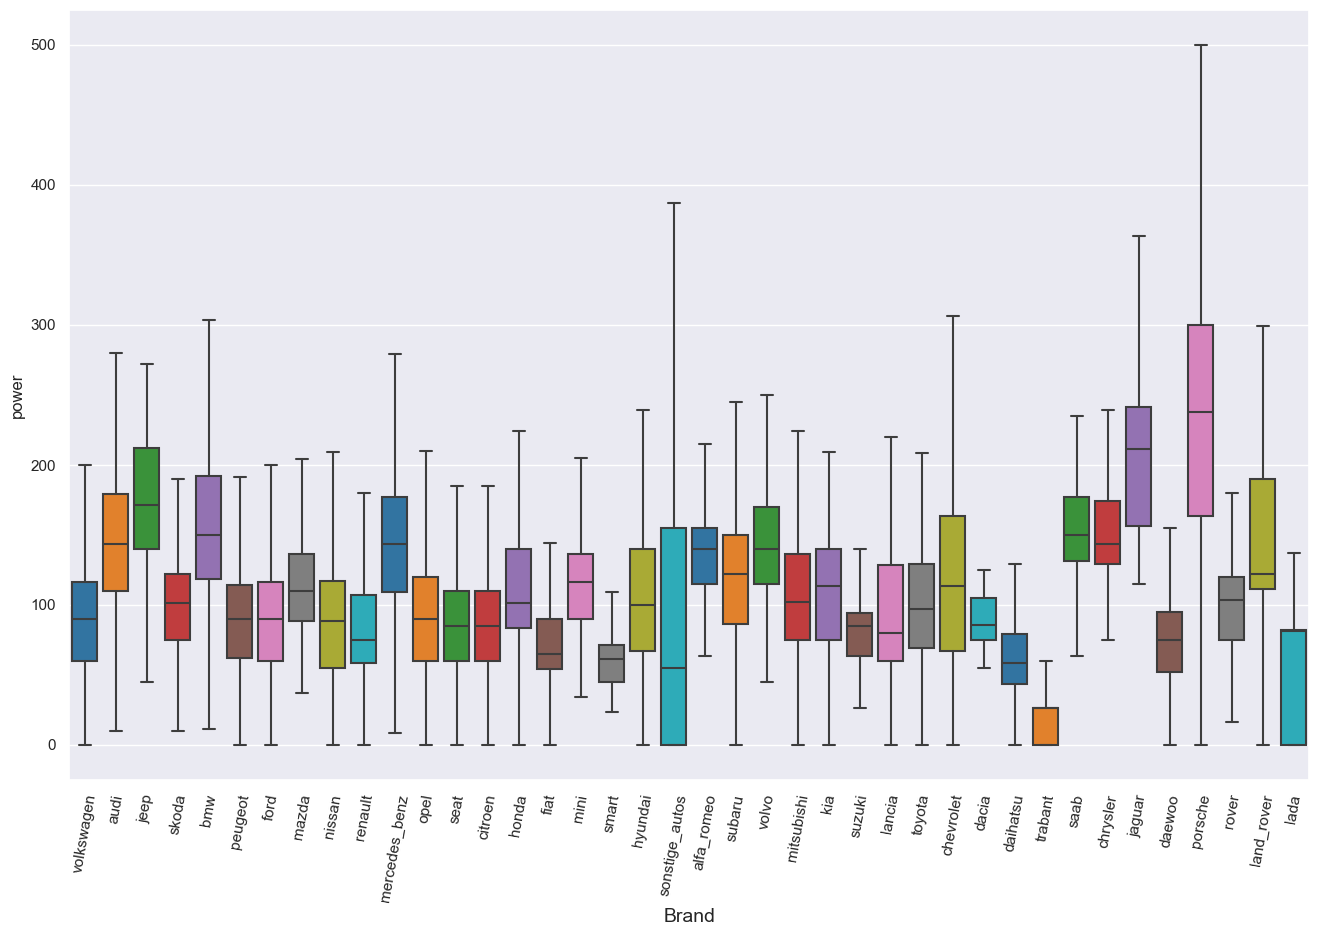

In [27]:
# Showing how our cars  distribut by their power
fig, axs = plt.subplots(1, 1, figsize=(16,10) )
sns.boxplot(data=df_upd, x="brand", y="power",  palette='tab10', showfliers=False, ax=axs)
plt.xticks(rotation=80)
axs.set_xlabel('Brand', fontsize=14);

In [28]:
#Function for solving problem with outliers
def out_perc(data,col_name):
    q1 = data[col_name].quantile(0.25)#The value located at the 25th percentile of our data in "model_year" column
    q3 = data[col_name].quantile(0.75)#The value located at the 75th percentile of our data in "model_year" column
    iqr = q3-q1 #Interquartile range- represents the spread of the middle 50% of the data
    fence_low  = q1-1.5*iqr# Min values range
    fence_high = q3+1.5*iqr# Max values range
    df_out = data.loc[(data[col_name] > fence_low) & (data[col_name] < fence_high)]
    outliers = len(data) - len(df_out)
    return print('Percentile of outliers in our Power features is {:.2%}'.format( outliers / len(data)))


#Calling our function
out_perc(df_upd,'power')

Percentile of outliers in our Power features is 2.08%


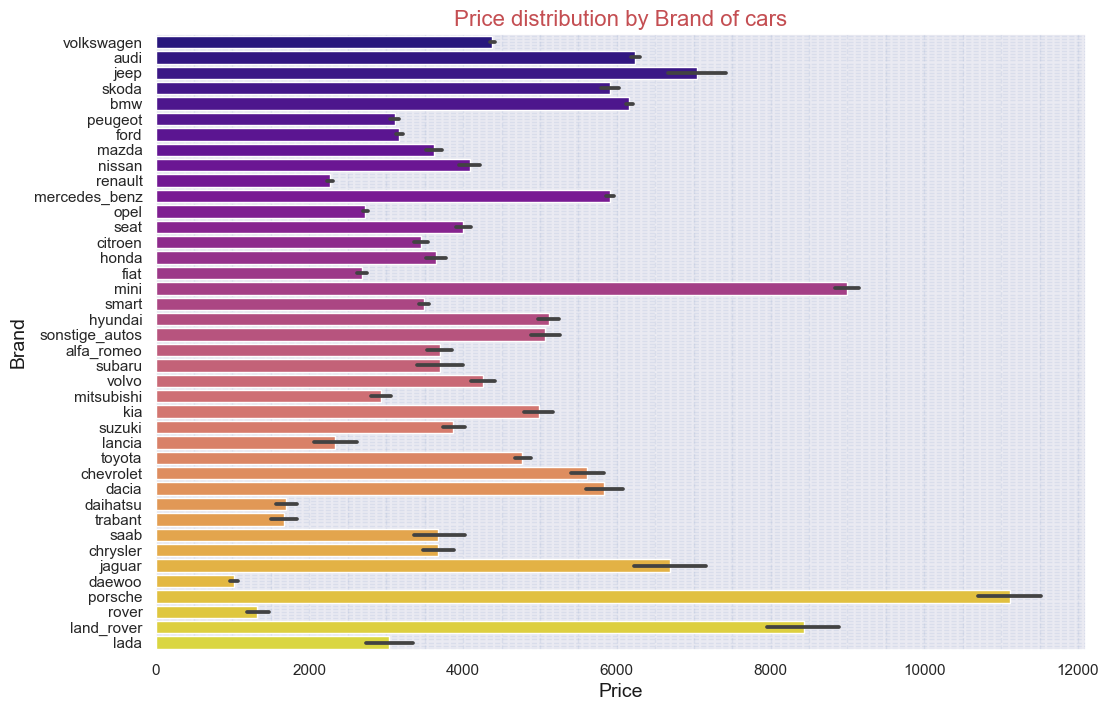

In [29]:
#create fig object
plt.figure(figsize=(12,8))

#horizontal bar chart showing the mean price of cars belong to each brand
sns.barplot(x='price', y='brand', data=df_upd,palette='plasma')

#customize the plot
plt.title('Price distribution by Brand of cars', fontsize=16, color='r')
plt.xlabel('Price', fontsize=14, color='k')
plt.ylabel('Brand', fontsize=14, color='k')
plt.grid(visible=True, which='both', color='b', linestyle='--', alpha=0.1)
plt.minorticks_on()
plt.show()

In [30]:
#Creating a new data set that will help us plot our graph
brand =pd.DataFrame(df_upd['brand'].value_counts().reset_index().rename(columns = {'index':'brand',
                                                                                      'brand':'amount'}))

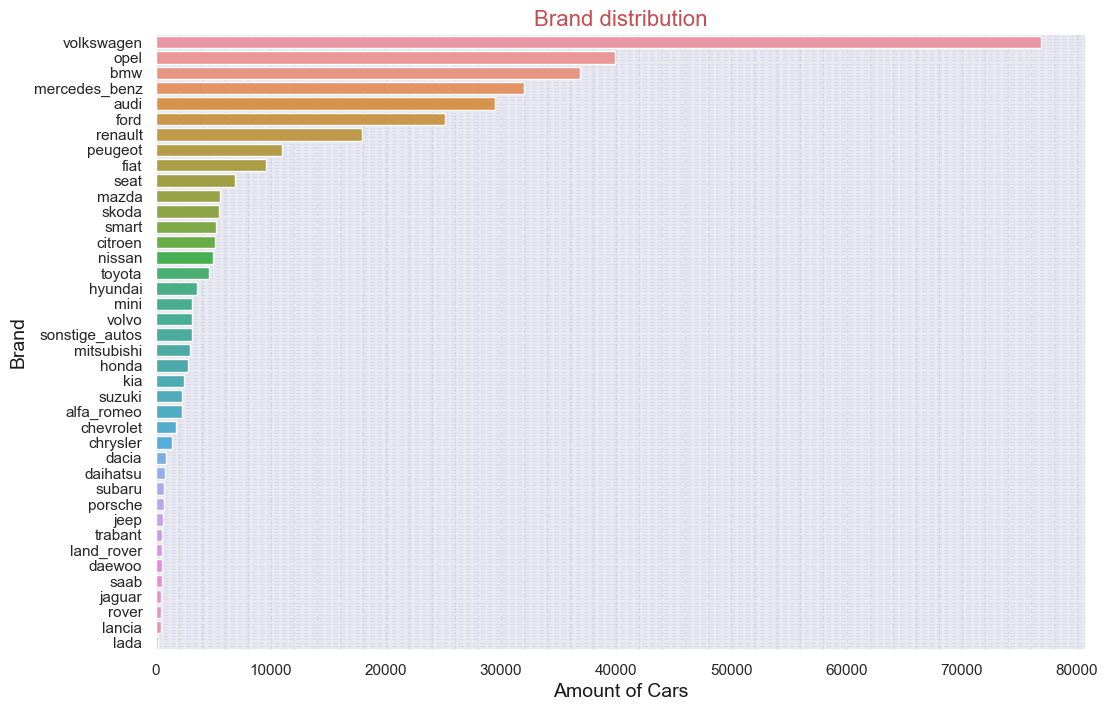

In [31]:

#create fig object
plt.figure(figsize=(12,8))

#horizontal bar chart showing number of cars belong to each brand
sns.color_palette("flare", as_cmap=True)
sns.barplot(x='amount', y='brand', data=brand)

#customize the plot
plt.title('Brand distribution', fontsize=16, color='r')
plt.xlabel('Amount of Cars', fontsize=14, color='k')
plt.ylabel('Brand', fontsize=14, color='k')
plt.grid(visible=True, which='both', color='b', linestyle='--', alpha=0.1)
plt.minorticks_on()
plt.show()

### Step 2. Data Analyzing

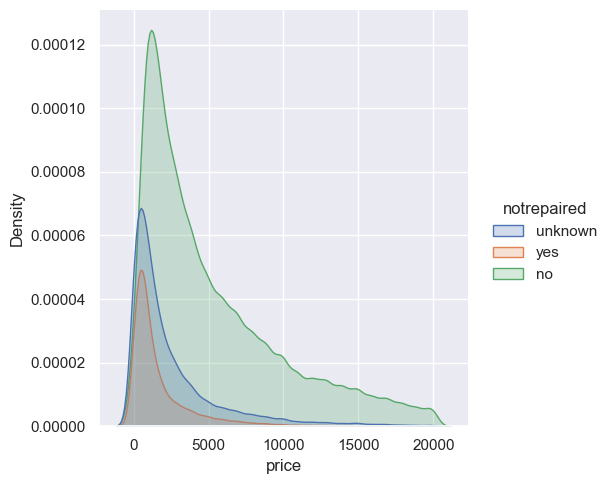

In [32]:
#Showing how our price depent of the condition of the car
sns.displot(df, x="price", hue="notrepaired", kind="kde", fill = True);

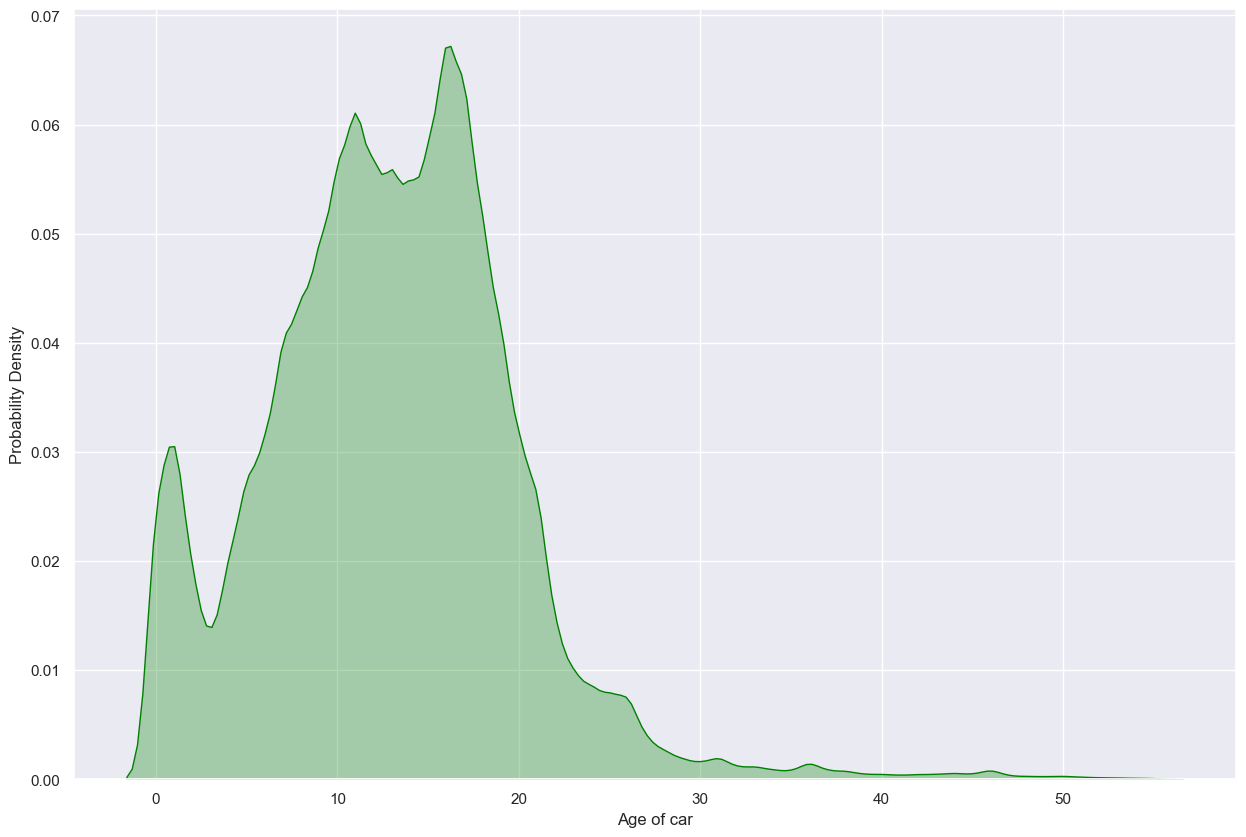

In [33]:
#let's build a age distribution density graph 
# Plotting the KDE Plot
sns.distplot(df_upd.ageofcar, hist=False, kde_kws={'shade':True, 'color':'green', 'alpha':0.3}, label='Good')
  
# Setting the X and Y Label
plt.xlabel('Age of car')
plt.ylabel('Probability Density')
plt.minorticks_on()
plt.show();

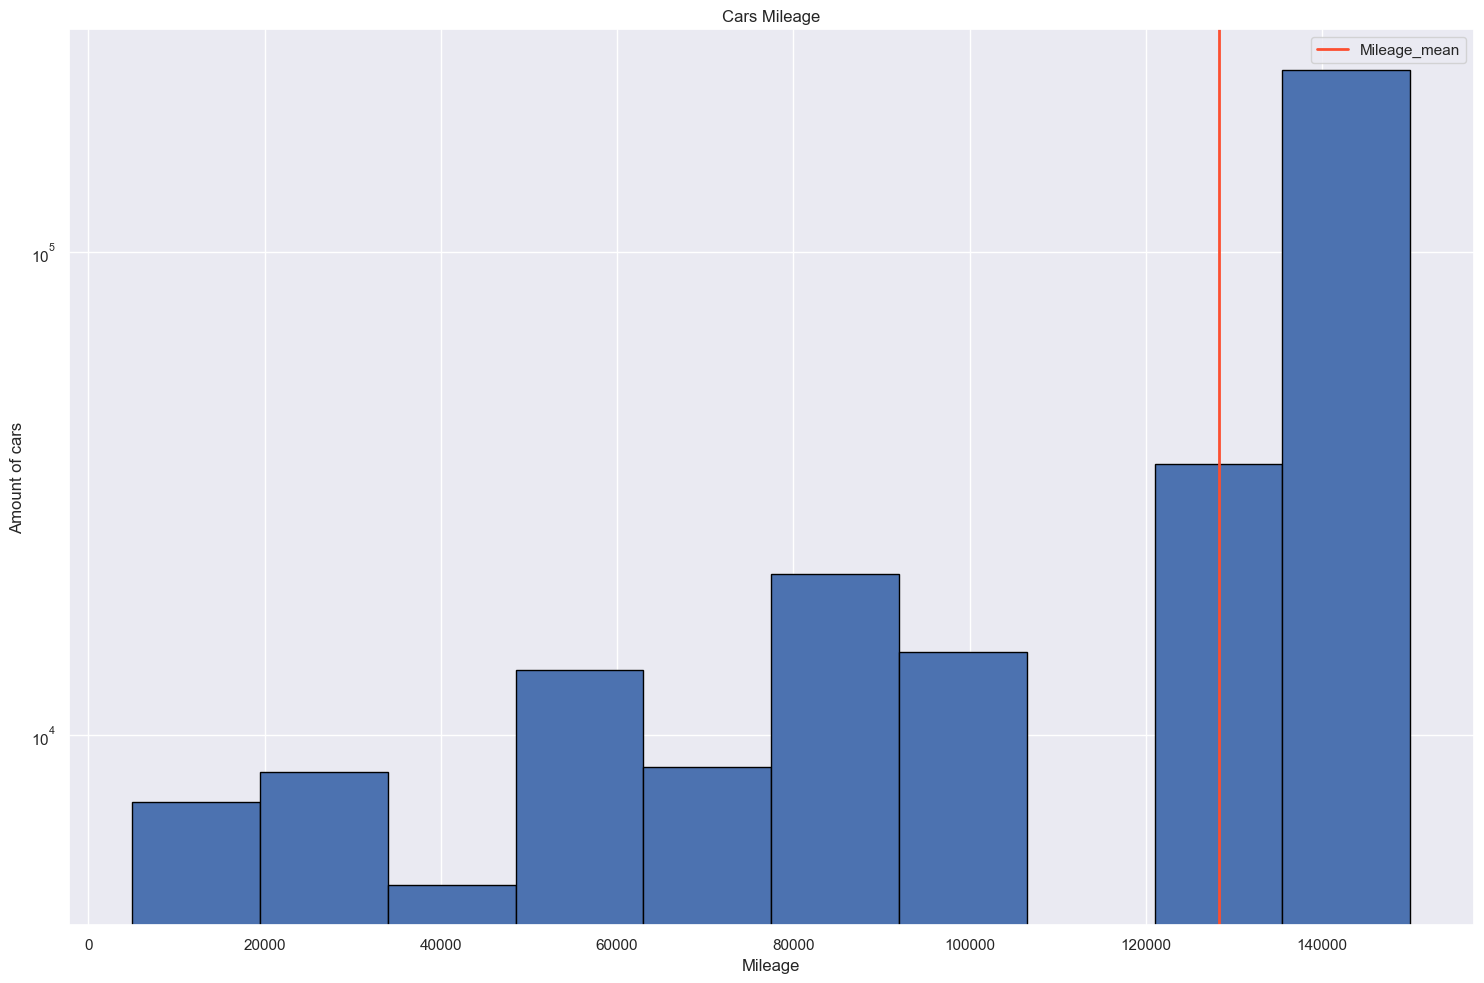

In [34]:
#showing what kind of age distribution we have in our "Mileage" feature + will show mean value
car_mil = df_upd['mileage']
mean_mil = car_mil.mean()
plt.hist(car_mil, edgecolor = 'black', log=True)
color = "#fc4f30"
plt.axvline(mean_mil, color=color, label="Mileage_mean", linewidth=2)
plt.legend()
plt.title("Cars Mileage")
plt.xlabel('Mileage')
plt.ylabel('Amount of cars')
plt.tight_layout()

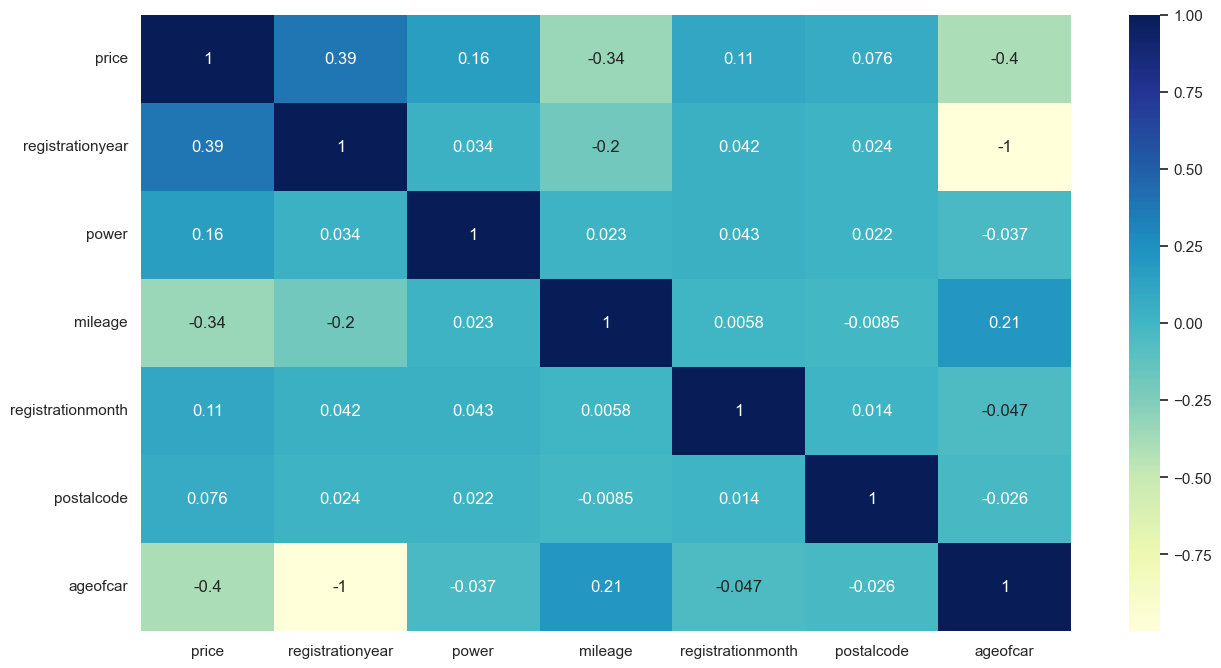

In [35]:
#Correlation in our data set
#Plotting heatmap of correlation of our dataset
df_corr =df_upd.drop("numberofpictures",axis=1)
plt.figure(figsize = (15,8))
sns.heatmap(df_corr.corr(),annot=True,cmap="YlGnBu");

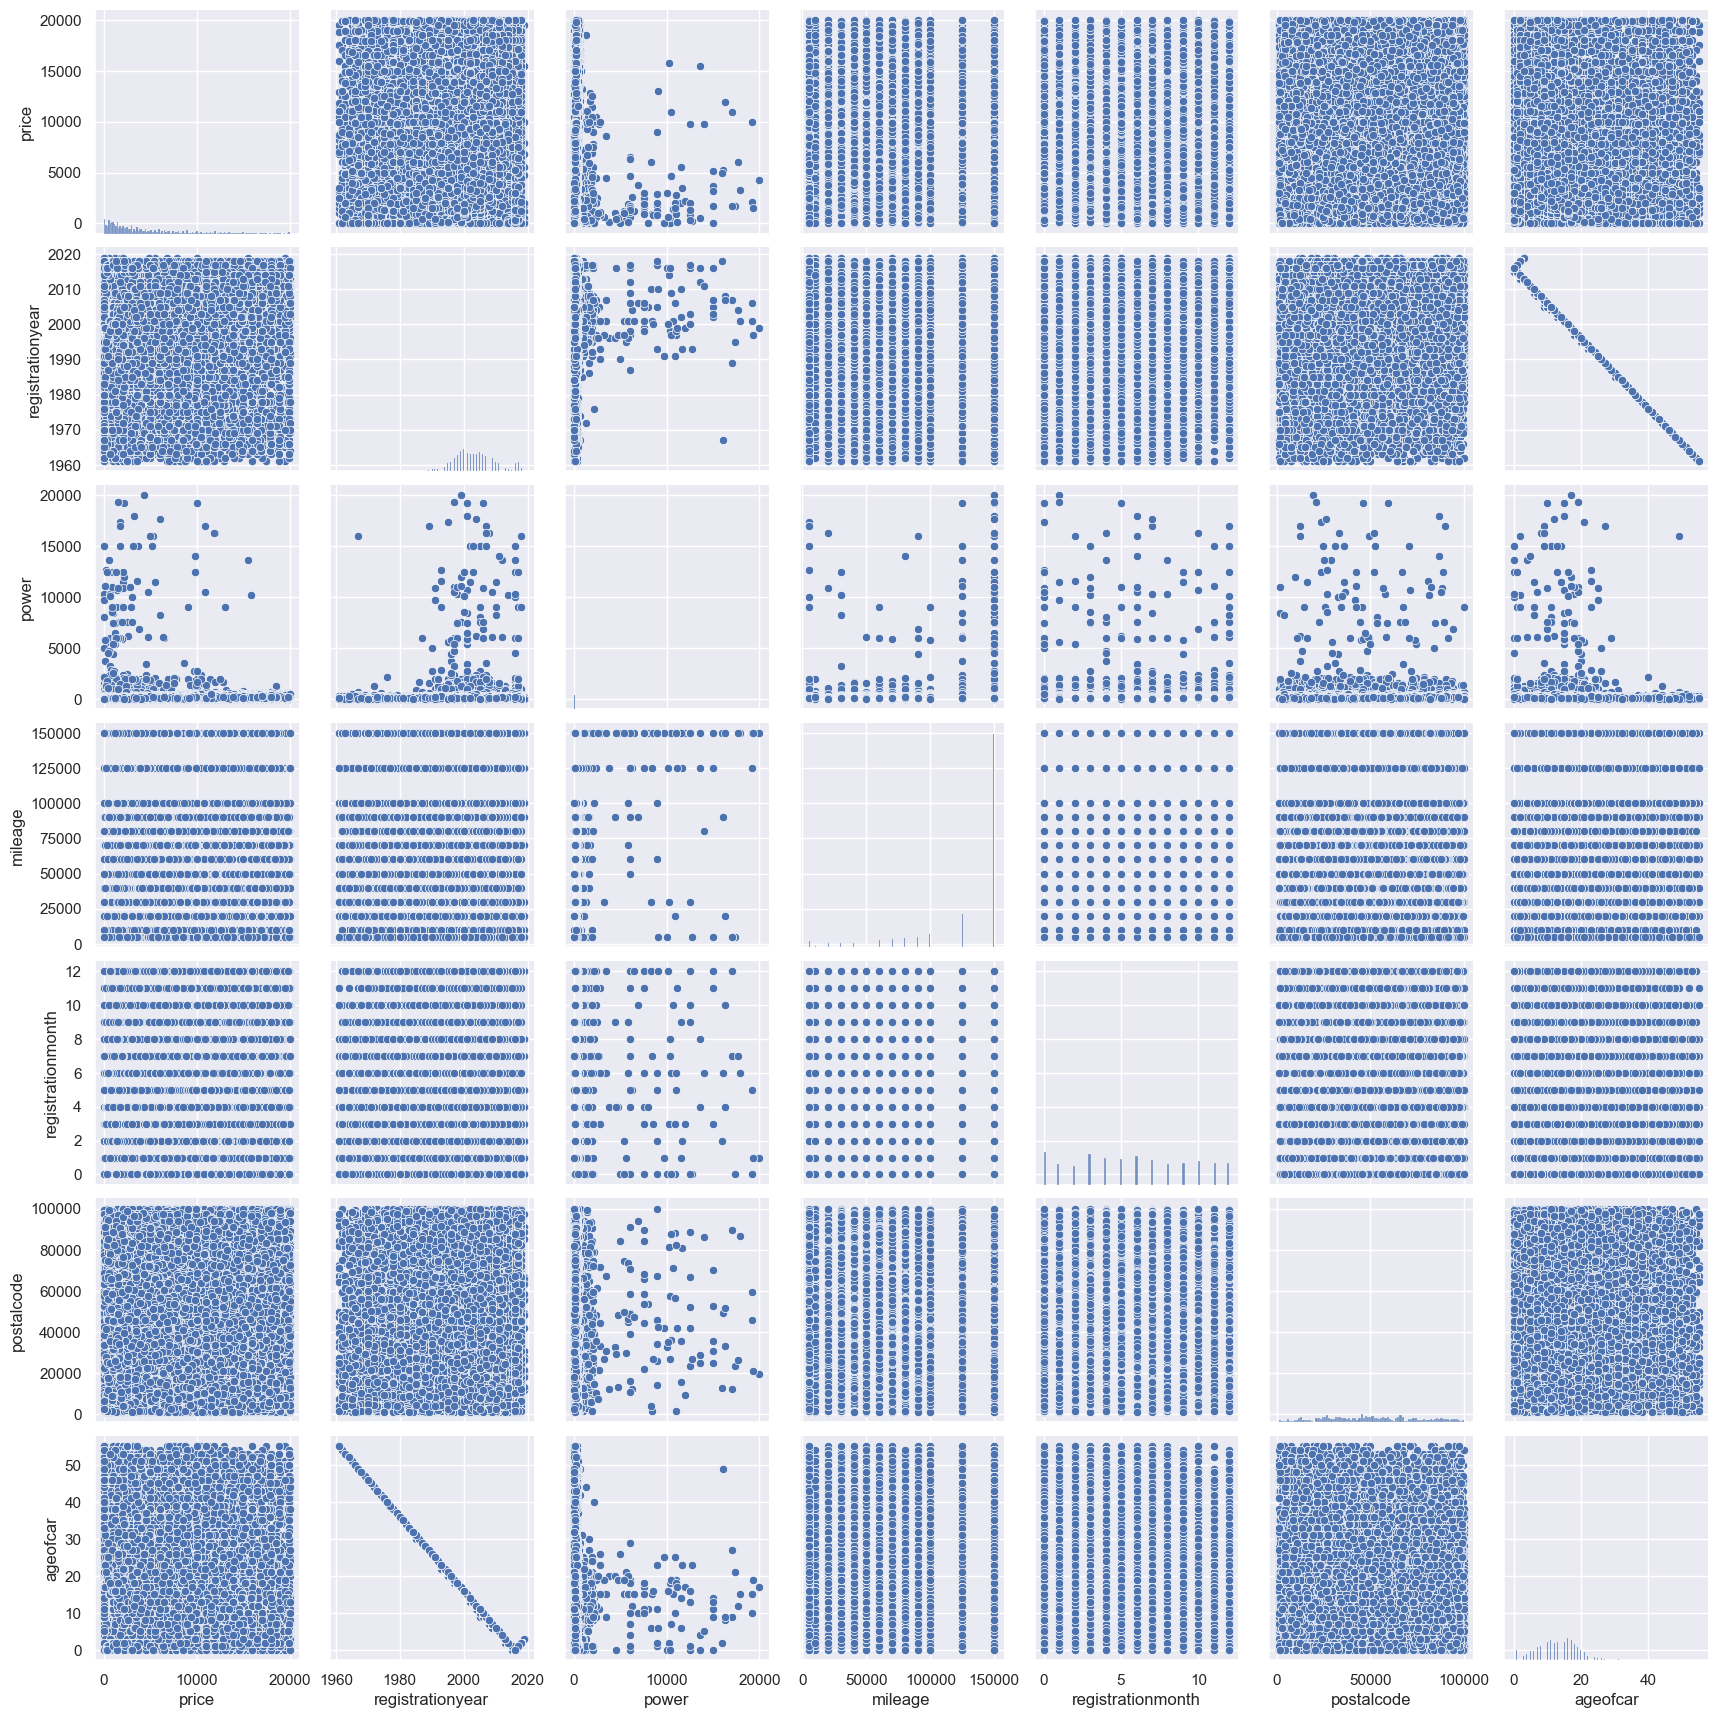

In [32]:
#Applying some additional visualization to showing correlation in our data
sns.pairplot(df_corr, palette='Set1');

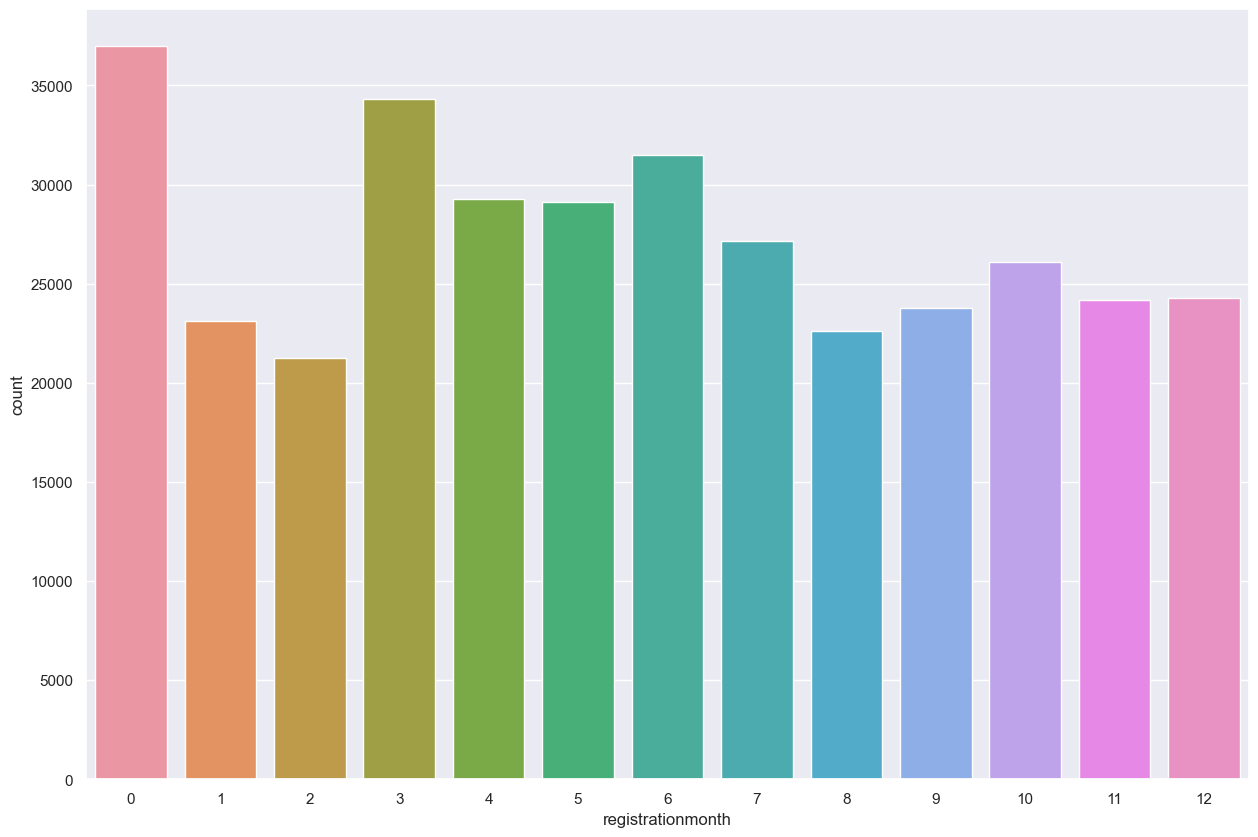

In [36]:
#Car register distribution by each month
sns.countplot(x=df_upd['registrationmonth'].sort_values());

> From last countplot we see that we have values belong to the month ‘‘‘0‘‘‘. We know that some scientist asign first month of the year by number ‘‘‘0‘‘‘ and another by ‘‘‘1‘‘‘ that why I propose to reasign all values equal to ‘‘‘0‘‘‘ by ‘‘‘1‘‘‘.

In [37]:
df_upd['registrationmonth'] = df_upd['registrationmonth'].replace(0,1)
df_upd['registrationmonth'].unique()

array([ 1,  5,  8,  6,  7, 10, 12, 11,  2,  3,  4,  9])

>Conclusion: After our exploration data analysis we can say that:
- First, most of our cars have run-and-drive conditions.
- Belong to a range of diapason from 10-20 year
- Has mileage from 120-140k.
- And near equally monthly registration distribution

### Step 3.  Model training

- But first need to prepar our data set that we can in further train our model
- Than we need to split our data into train and valid set
- After we will get our necessary data sets we will start working with our algorith

In [40]:
#Cheking if our numberofpictures can provide to us any neccessary information
df_upd['numberofpictures'].unique()

array([0])

In [41]:
# Droping all unecessary columns
drop_col = ['datecrawled','datecreated','lastseen','postalcode','numberofpictures']
df_final =  df_upd.drop(drop_col,axis=1)
df_final

price  vehicletype  registrationyear gearbox  power        model  \
0         480        other              1993  manual      0         golf   
1       18300        coupe              2011  manual    190        other   
2        9800          suv              2004    auto    163        grand   
3        1500        small              2001  manual     75         golf   
4        3600        small              2008  manual     69        fabia   
...       ...          ...               ...     ...    ...          ...   
354364      0        other              2005  manual      0         colt   
354365   2200        other              2005    auto      0        other   
354366   1199  convertible              2000    auto    101       fortwo   
354367   9200          bus              1996  manual    102  transporter   
354368   3400        wagon              2002  manual    100         golf   

        mileage  registrationmonth  fueltype           brand notrepaired  \
0        150000                  1    petrol      volkswagen     unknown   
1        125000                  5  gasoline            audi         yes   
2        125000                  8  gasoline            jeep     unknown   
3        150000                  6    petrol      volkswagen          no   
4         90000                  7  gasoline           skoda          no   
...         ...                ...       ...             ...         ...   
354364   150000                  7    petrol      mitsubishi         yes   
354365    20000                  1  gasoline  sonstige_autos     unknown   
354366   125000                  3    petrol           smart          no   
354367   150000                  3  gasoline      volkswagen          no   
354368   150000                  6  gasoline      volkswagen     unknown   

        ageofcar  
0             23  
1              5  
2             12  
3             15  
4              8  
...          ...  
354364        11  
354365        11  
354366        16  
354367        20  
354368        14  

[353654 rows x 12 columns]

In [42]:

#Our necessary preprocessing functions
encoder = OrdinalEncoder()
#creating a list of categorigal features that we will encode in the furher steps
categorical = ['vehicletype','gearbox','model','fueltype','brand','notrepaired']
#Fitting and Transforming our data set, and creating a new one
df_ord = pd.DataFrame(encoder.fit_transform(df_final[categorical]),columns = df_final[categorical].columns)
df_ord.sample(5)

vehicletype  gearbox  model  fueltype  brand  notrepaired
278884          5.0      1.0   83.0       6.0   24.0          0.0
6885            7.0      1.0  170.0       2.0   38.0          0.0
13322           5.0      1.0  120.0       6.0   30.0          0.0
235213          0.0      0.0  116.0       2.0   38.0          0.0
124778          7.0      1.0   29.0       6.0    1.0          0.0

In [43]:
#List of numeric features  which we will standardize
numeric = ['power', 'mileage', 'ageofcar', 'registrationyear','registrationmonth']
scaler= StandardScaler()
df_scaler = pd.DataFrame(scaler.fit_transform(df_final[numeric]),columns = df_final[numeric].columns)
df_scaler.sample(5)

power   mileage  ageofcar  registrationyear  registrationmonth
21762  -0.106490  0.573854  1.157730         -1.141550           0.048748
107756 -0.117037 -1.547754 -0.420564          0.394851           1.727941
337393  0.278493  0.573854  0.153361         -0.163840           0.608479
239072  0.136102  0.573854  0.009880         -0.024168           1.168210
19966   0.157197  0.573854 -0.277083          0.255178           0.888344

In [44]:
#Now we need to combine to our new data sets 

df = pd.concat([df_ord,df_scaler],axis=1)
df.sample(5)

vehicletype  gearbox  model  fueltype  brand  notrepaired     power  \
42806           7.0      0.0   29.0       2.0    1.0          0.0  0.173018   
179441          5.0      1.0   41.0       6.0   30.0          2.0 -0.317440   
349118          4.0      1.0  166.0       2.0   12.0          0.0 -0.148680   
344536          7.0      0.0   95.0       2.0   20.0          0.0  0.352326   
214306          4.0      1.0  116.0       6.0   38.0          0.0 -0.106490   

         mileage  ageofcar  registrationyear  registrationmonth  
42806  -0.089148 -1.281451          1.232887           0.328614  
179441  0.573854  0.870767         -0.862204           1.727941  
349118 -0.089148 -0.420564          0.394851           1.727941  
344536  0.573854  0.009880         -0.024168           1.727941  
214306  0.573854  1.157730         -1.141550          -1.070713

> Now after we finished all the preparation we can start working with our data and algorithms, let's split our data into ‘‘‘Train‘‘‘ and ‘‘‘Valid‘‘‘sets, than by using the feature selection methods will take only those features that provide impact on our prediction, and will calculate what model will provide to us better result of prediction

In [45]:
X = df
Y = df_upd['price']

X_train, X_valid, y_train, y_valid = train_test_split(X,Y, test_size=0.25, random_state= 12345)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)


(265240, 11)
(265240,)
(88414, 11)
(88414,)


In [46]:
#For the first method let's use filter method K-best Features with help of GradientBoostingRegressor
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = X_train.copy(),X_valid.copy(),y_train.copy(),y_valid.copy()
gbr =  GradientBoostingRegressor(max_depth=5,random_state=42)
r2_score_list=[]
for k in range(1,12):# 11 features in our dataset
    selector=SelectKBest(mutual_info_regression,k=k)
    selector.fit(X_train,y_train)
    sel_X_train_v2= selector.transform(X_train_v2)
    sel_X_test_v2=selector.transform(X_test_v2)
    
    gbr.fit(sel_X_train_v2,y_train_v2)
    kbest_preds= gbr.predict(sel_X_test_v2)
    r2_score_kbest=round(r2_score(y_test_v2,kbest_preds),3)
    r2_score_list.append(r2_score_kbest)

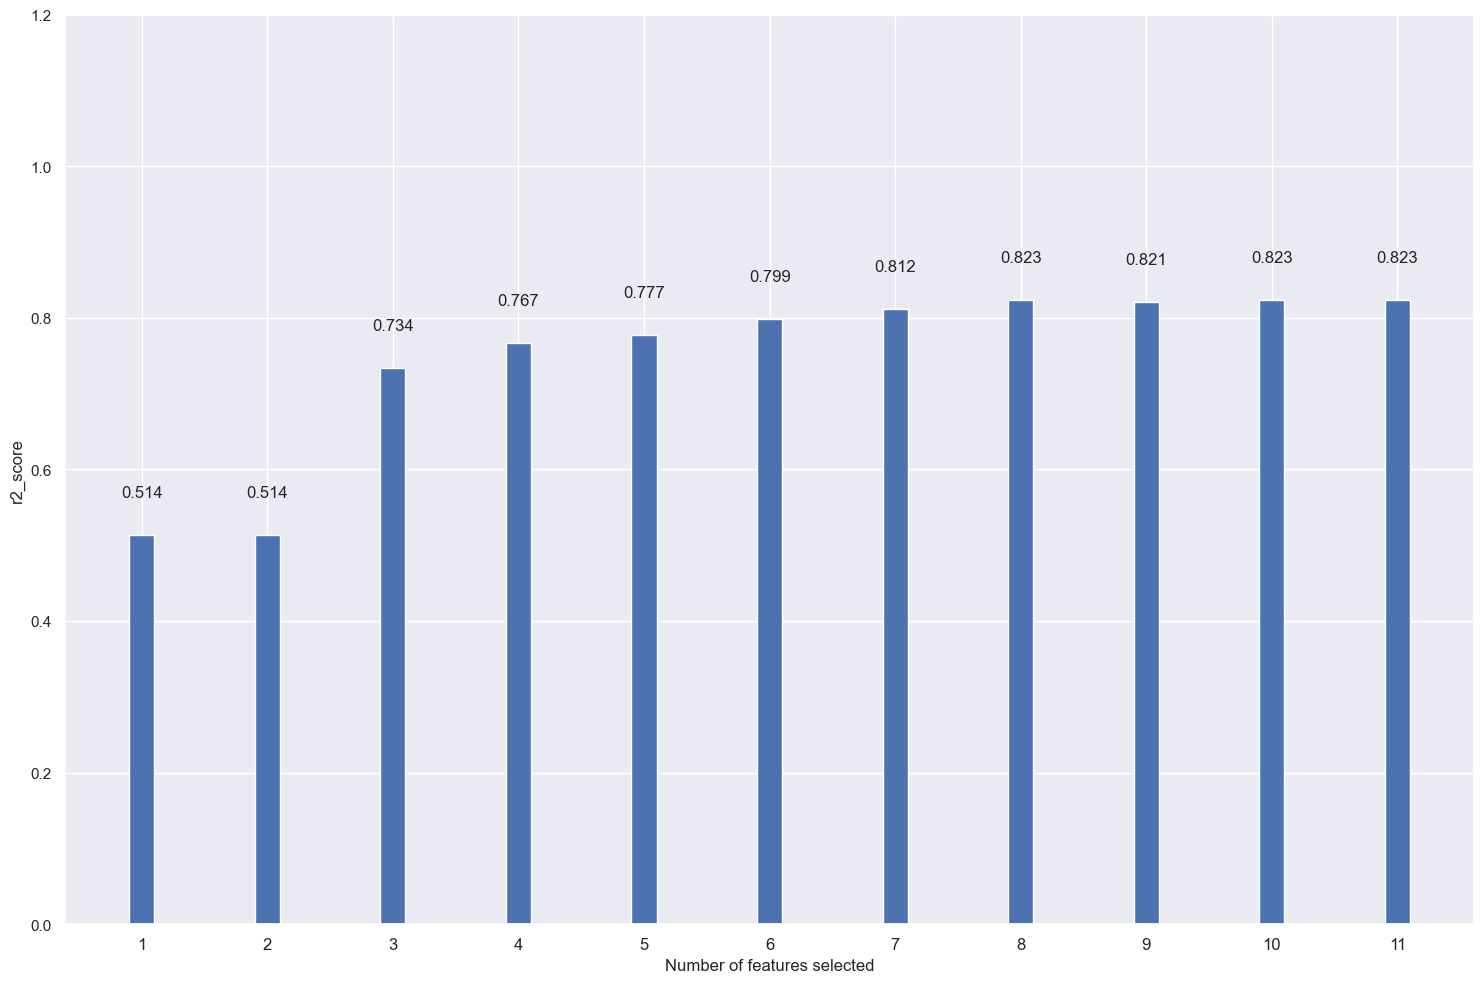

In [47]:
fig, ax= plt.subplots()
x = np.arange(1,12)
y = r2_score_list
ax.bar(x,y,width=0.2)
ax.set_xlabel('Number of features selected')
ax.set_ylabel('r2_score')
ax.set_ylim(0,1.2)
ax.set_xticks(np.arange(1,12))
ax.set_xticklabels(np.arange(1,12),fontsize=12)
for i, v in enumerate(y):
    plt.text(x=i+1,y=v+0.05,s=str(v),ha='center')

plt.tight_layout()

> By our first filter method we see that we can workwith only 8 features and we will have the same result as if we willw work with all features in our data set. Let's check what are those best features

In [48]:
selector = SelectKBest(mutual_info_regression,k=8)
selector.fit(X_train_v2,y_train_v2)
selected_features_mask = selector.get_support()

selected_features = X_train_v2.columns[selected_features_mask]
selected_features

Index(['vehicletype', 'model', 'brand', 'notrepaired', 'power', 'mileage',
       'ageofcar', 'registrationyear'],
      dtype='object')

> Now we will work with auto selection method **Boruta**  and **XGBregressor** and see what we will have there.

In [49]:
model = xgb.XGBRegressor()#Creating our model
feat_selector = BorutaPy(model,n_estimators='auto',verbose=True,random_state=1234)#Assigned our selector 
feat_selector.fit(X_train_v2.values,y_train_v2.values.ravel())


Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	0


BorutaPy(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                feature_types=None, gamma=None, gpu_id=None,
                                grow_policy=None, importance_type=None,
                                interaction_constraints=None,
                                learning_rate=None, max_bin=None,
                                max_cat_threshold=None, max_cat_to_onehot=None,
                                max_delta_step=None, max_depth=None,
                                max_leaves=None, min_child_weight=None,
                                missing=nan, monotone_constraints=None,
                                n_estimators=46, n_jobs=None,
                                num_parallel_tree=None, predictor=None,
                                random_state=1929357999, ...),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x16CDAEB40,
         verbose=True)

> Boruta model show us that all 11 features a provide a reasonable impact to our model, but from previous filter method we saw that 8 features wil be enoght, so we can simple drop all unecessary features and move on, but on this step I propose work with all features because we have not have so big amount of them and have only 11.
- Now we can start working with our algorithms, here we will use two of them, **XGBoost** and **LightGBM** and will compare them to each other to see how long and how good they working

In [50]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_valid)
    mae =  mean_absolute_error(y_valid, predictions)
    return mae



In [51]:
study = optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=10)

[I 2023-09-24 18:34:18,473] A new study created in memory with name: no-name-e3ae3d06-081f-47bc-a15a-537477a01f6b
[I 2023-09-24 18:34:31,667] Trial 0 finished with value: 2176.279450256084 and parameters: {'learning_rate': 0.001191195017591473, 'max_depth': 2, 'subsample': 0.5015085594569925, 'colsample_bytree': 0.6616784424478238, 'min_child_weight': 15}. Best is trial 0 with value: 2176.279450256084.
[I 2023-09-24 18:34:47,951] Trial 1 finished with value: 2062.135766249078 and parameters: {'learning_rate': 0.0011784030641250633, 'max_depth': 3, 'subsample': 0.5102441412672707, 'colsample_bytree': 0.49637749070057435, 'min_child_weight': 2}. Best is trial 1 with value: 2062.135766249078.
[I 2023-09-24 18:35:07,184] Trial 2 finished with value: 1876.1292877117878 and parameters: {'learning_rate': 0.0012545659198018922, 'max_depth': 4, 'subsample': 0.9168529553696525, 'colsample_bytree': 0.9524808936703967, 'min_child_weight': 12}. Best is trial 2 with value: 1876.1292877117878.
[I 202

In [52]:
print('Best hyperparameters:', study.best_params)
print('Best mae:', study.best_value)

Best hyperparameters: {'learning_rate': 0.018817149195541467, 'max_depth': 8, 'subsample': 0.3278515276516298, 'colsample_bytree': 0.4461477027903469, 'min_child_weight': 7}
Best RMSE: 1070.3039917214803


In [53]:
#add visualization to our method
plot_optimization_history(study)

> After we found the best hyperparameters for our modelі we can start working.

In [59]:
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_valid, y_valid, enable_categorical=True)

In [61]:
params = study.best_params
params

{'learning_rate': 0.018817149195541467,
 'max_depth': 8,
 'subsample': 0.3278515276516298,
 'colsample_bytree': 0.4461477027903469,
 'min_child_weight': 7}

In [62]:
%%time
#XGB model
model =xgb.train(
    params,
    dtrain_reg,
    num_boost_round = 747,
    evals = [(dtest_reg, "Test")],
    early_stopping_rounds = 10

    
)
print("MAE: fro XGB model is: {:.2f} ".format(
    model.best_score))

[0]	Test-rmse:6213.80338
[1]	Test-rmse:6143.71788
[2]	Test-rmse:6055.26995
[3]	Test-rmse:5986.87839
[4]	Test-rmse:5892.89266
[5]	Test-rmse:5809.66756
[6]	Test-rmse:5728.95950
[7]	Test-rmse:5650.98202
[8]	Test-rmse:5562.73780
[9]	Test-rmse:5478.07474
[10]	Test-rmse:5408.92622
[11]	Test-rmse:5332.21212
[12]	Test-rmse:5266.21835
[13]	Test-rmse:5203.05260
[14]	Test-rmse:5140.50210
[15]	Test-rmse:5069.16264
[16]	Test-rmse:5002.95308
[17]	Test-rmse:4944.05595
[18]	Test-rmse:4878.66466
[19]	Test-rmse:4806.34653
[20]	Test-rmse:4743.32355
[21]	Test-rmse:4689.08337
[22]	Test-rmse:4628.01230
[23]	Test-rmse:4578.75463
[24]	Test-rmse:4518.55853
[25]	Test-rmse:4454.73022
[26]	Test-rmse:4405.68577
[27]	Test-rmse:4362.78692
[28]	Test-rmse:4306.20229
[29]	Test-rmse:4247.52163
[30]	Test-rmse:4188.82722
[31]	Test-rmse:4135.99124
[32]	Test-rmse:4097.94070
[33]	Test-rmse:4049.08816
[34]	Test-rmse:4003.69126
[35]	Test-rmse:3960.61919
[36]	Test-rmse:3921.48576
[37]	Test-rmse:3879.27006
[38]	Test-rmse:3835.90

[308]	Test-rmse:1835.31114
[309]	Test-rmse:1835.17720
[310]	Test-rmse:1834.64436
[311]	Test-rmse:1833.97384
[312]	Test-rmse:1833.49293
[313]	Test-rmse:1833.11505
[314]	Test-rmse:1832.91254
[315]	Test-rmse:1832.31094
[316]	Test-rmse:1831.78827
[317]	Test-rmse:1831.57229
[318]	Test-rmse:1831.24147
[319]	Test-rmse:1830.83535
[320]	Test-rmse:1830.32943
[321]	Test-rmse:1829.64718
[322]	Test-rmse:1828.86547
[323]	Test-rmse:1828.21669
[324]	Test-rmse:1827.89397
[325]	Test-rmse:1827.35597
[326]	Test-rmse:1826.81846
[327]	Test-rmse:1826.19815
[328]	Test-rmse:1825.80497
[329]	Test-rmse:1825.40715
[330]	Test-rmse:1824.87230
[331]	Test-rmse:1824.41233
[332]	Test-rmse:1824.22525
[333]	Test-rmse:1823.67814
[334]	Test-rmse:1823.49560
[335]	Test-rmse:1823.13980
[336]	Test-rmse:1822.41007
[337]	Test-rmse:1821.87060
[338]	Test-rmse:1821.56331
[339]	Test-rmse:1821.17186
[340]	Test-rmse:1820.59129
[341]	Test-rmse:1820.29641
[342]	Test-rmse:1819.75323
[343]	Test-rmse:1819.47095
[344]	Test-rmse:1818.83214
[

[612]	Test-rmse:1772.96203
[613]	Test-rmse:1772.81131
[614]	Test-rmse:1772.69483
[615]	Test-rmse:1772.65177
[616]	Test-rmse:1772.53313
[617]	Test-rmse:1772.49391
[618]	Test-rmse:1772.35376
[619]	Test-rmse:1772.30977
[620]	Test-rmse:1772.22689
[621]	Test-rmse:1772.14042
[622]	Test-rmse:1772.01392
[623]	Test-rmse:1771.94745
[624]	Test-rmse:1771.75733
[625]	Test-rmse:1771.68880
[626]	Test-rmse:1771.58111
[627]	Test-rmse:1771.51061
[628]	Test-rmse:1771.48851
[629]	Test-rmse:1771.30503
[630]	Test-rmse:1771.23121
[631]	Test-rmse:1771.21779
[632]	Test-rmse:1771.04582
[633]	Test-rmse:1771.06801
[634]	Test-rmse:1770.97255
[635]	Test-rmse:1770.79919
[636]	Test-rmse:1770.73296
[637]	Test-rmse:1770.62065
[638]	Test-rmse:1770.58230
[639]	Test-rmse:1770.55355
[640]	Test-rmse:1770.39288
[641]	Test-rmse:1770.27882
[642]	Test-rmse:1770.11799
[643]	Test-rmse:1770.06284
[644]	Test-rmse:1770.01628
[645]	Test-rmse:1770.00158
[646]	Test-rmse:1769.81680
[647]	Test-rmse:1769.73231
[648]	Test-rmse:1769.48162
[

### Overall conclusion:
- After loading the data set and looking inside we found that we have in several columns a big number of missing values the amount of them was near **50%** of all data set.
- Then we started to the necessary steps to refill and solve our problem with the data set, which is called **Data preprocessing**.
- In the next step, we provided some data analysis with additional visualization we saw that the **sedan** is the most popular type of car, and the fastest and most expensive car in our list is **Porshe** and the famous brand of our car is **Volkswagen**. We see that ppl still prefer to use **petrol** fuel.
- After that, we provide some statistics analysis to show what kind of **price**, **age**, and **mileage** we have in our data set.
- From the correlation heatmap, we found out that our car **price** in most cases has a higher dependency on **the age of the car and power**.
- When we finished all our data preparation and exploration data analysis we started moving straight to preparing our training and test sets so that we could start working with our models.
- By using two types of feature selection methods **Filter** and **Wraphed** we found out that we can use not all our features and get the same result as if we use all of them, in another dataset if we have more than 15 or 20 features we could use this strategy to simplify and to make our model work faster, but here we have only 11 features and simple dataset.
- In this stage, we work with our **XGB model**. In the first step, we evaluate the best **hyperparameters and MAE** of the model, after we define the best hyperparameters we start working with our algorithm by tunning best hyperparameters.
- In the end, we found that by using our model we got, **MAE: 1764, and time: 24.5s**.

